# Fake News Detection NLP - Model Creation

**Goal:** To make an NLP algorithm that can detect whether an article is fake news with a high degree of accuracy. This second notebook is designed entirely for the purpose of having a preliminary model that I can start with. If it works well enough then it can be my primary model; otherwise, I can use it to work out what to improve and proceed from there (either with some actual work or else by planning for future work).

In [199]:
##================#
# Libaries
##================#
import pandas as pd
from pandas.errors import ParserError
import numpy as np
import ast
import regex as re

import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import gensim
import gensim.downloader as api
from gensim.models.keyedvectors import KeyedVectors
from gensim.models import Word2Vec

from sklearn.feature_extraction.text import CountVectorizer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Conv1D, MaxPool1D
from tensorflow.keras.preprocessing.text import Tokenizer

I am also using Google's Word2Vec for this capstone. While I could make my own Word2Vec model using Gensim, this initial model is being trained on older articles (dating no later than early 2018) and as such relying on my current data to generate my model would likely cause me to run into some issues if I later test with newer articles.

In [158]:
# API download word2vec to save on cloud, download needs
vec_path = api.load("word2vec-google-news-300", return_path=True)
print(vec_path)

C:\Users\Salan/gensim-data\word2vec-google-news-300\word2vec-google-news-300.gz


In [163]:
##================#
# Load Train ISOT
##================#
train_df = pd.read_csv('data/processedISOT/Train.csv')

# Drop "Unnamed: 0" column, which exists for some reason
train_df = train_df.drop('Unnamed: 0', axis=1)

# Quick test
train_df.head()

,fake_news,tokens
0,0,"['kenyan', 'police', 'fired', 'teargas', 'tues..."
1,1,"['apparently', 'new', 'world', 'one', 'perfect..."
2,0,"['hong', 'kong', 'seeks', 'land', 'help', 'eas..."
3,0,"['spain', 'friday', 'issued', 'arrest', 'warra..."
4,0,"['iranian', 'military', 'vessel', 'confronted'..."


### Define Features, Vectorize
I already have my tokens, and have chosen to utilize Word2Vec so I do not need the original text to train or test my data. If I were employing a different strategy, such as BERT, then I would have wanted to keep and tokenize sentences instead.

In [164]:
# Features: X is defined later
y = train_df['fake_news']

# X will be the following:
print(train_df['tokens'])

0        ['kenyan', 'police', 'fired', 'teargas', 'tues...
1        ['apparently', 'new', 'world', 'one', 'perfect...
2        ['hong', 'kong', 'seeks', 'land', 'help', 'eas...
3        ['spain', 'friday', 'issued', 'arrest', 'warra...
4        ['iranian', 'military', 'vessel', 'confronted'...
                               ...                        
30981    ['russia', 'upper', 'house', 'parliament', 'we...
30982    ['heard', 'offshore', 'accounts', 'wealthy', '...
30983    ['president', 'donald', 'trump', 'poised', 're...
30984    ['white', 'house', 'said', 'friday', 'set', 'k...
30985    ['ha', 'pbs', 'live', 'feed', 'facebook', 'dem...
Name: tokens, Length: 30986, dtype: object


I also needed to decide on a good embedding size for my own Word2Vec, yet I wanted a consistent number to ensure that my variables would be easy enough to plug into a model. Google's embedding size was 300, but it also had a very large dataset to work with so I figured working with a higher-dimensionality than that could ensure I get at least somewhat similar results for terms I should expect to find in my dataset.

I define "Vectorizer B" first, because that is the pre-trained Word2Vec and much of the code written after will involve "Vectorizer A". In other words, I did it for organization.

In [123]:
##================#
# Vectorizer B
##================#
# Import Google's vectorizer for version B of the model
w2v_b = gensim.models.KeyedVectors.load_word2vec_format(vec_path, binary=True)

In [165]:
# Predefined argument 1 - Embedding Size
embed_dim = 512

In [166]:
##================#
# Vectorizer A
##================#
token_lists = train_df['tokens']
sentences = [ast.literal_eval(tokens) for tokens in token_lists if tokens]
w2v_a = Word2Vec(sentences=sentences, vector_size=embed_dim, min_count=1)

In [167]:
# Predefined argument 2 - Size of Vocabulary
vocab_length = len(w2v_a.wv.key_to_index) + 1
vocab_length

157641

Doing some quick tests, first with my own Word2Vec model:

In [168]:
# Word similarity test 1a
w2v_a.wv.most_similar(positive="canada")

[('mexico', 0.6616427302360535),
 ('nafta', 0.6612692475318909),
 ('australia', 0.6470847725868225),
 ('canadian', 0.6032117009162903),
 ('tariff', 0.5997135639190674),
 ('dairy', 0.5830290913581848),
 ('peso', 0.5792645812034607),
 ('doingread', 0.5736428499221802),
 ('renegotiation', 0.5734514594078064),
 ('tariffs', 0.5719848871231079)]

In [169]:
# Word similarity test 1b
w2v_a.wv.most_similar(positive="oak")

[('creek', 0.8483708500862122),
 ('riverside', 0.843809187412262),
 ('centro', 0.8418642282485962),
 ('vista', 0.8284909725189209),
 ('hillside', 0.8220389485359192),
 ('marketed', 0.8195032477378845),
 ('upscale', 0.8181023001670837),
 ('overnightwitnesses', 0.8178741335868835),
 ('hollister', 0.8150315880775452),
 ('fountain', 0.8094220161437988)]

And then with Google's:

In [71]:
# Word similarity test 2a
w2v_b.most_similar('canada')

[('australia', 0.7359464168548584),
 ('usa', 0.7136157155036926),
 ('canadian', 0.6989886164665222),
 ('uk', 0.6821740865707397),
 ('india', 0.6490968465805054),
 ('microsoft', 0.6283592581748962),
 ('malaysia', 0.6214037537574768),
 ('turbotax', 0.6093018054962158),
 ('mexico', 0.6087307333946228),
 ('ireland', 0.6055781245231628)]

In [111]:
# Word similarity test 2b
w2v_b.most_similar('oak')

[('cedar', 0.6967766284942627),
 ('oaks', 0.6850836277008057),
 ('walnut', 0.6754781007766724),
 ('pine', 0.6602115631103516),
 ('oak_trees', 0.6532793045043945),
 ('beech', 0.6491631865501404),
 ('redwood', 0.6438664197921753),
 ('birch', 0.6352806091308594),
 ('sycamore', 0.6303034424781799),
 ('Douglas_fir', 0.6284433007240295)]

As can be seen here, the vectors seem to be picking up on some of the same relationships, but Google's is more comprehensive because it was trained on a much larger dataset than I am using, while my data is based entirely on world or political news; it is also restricted to a small period of time, which further limits its potential.

That said, my own Word2Vec's vocabulary is comprised of over 157,000 terms that were learned from a high relevant dataset. While it is unlikely that all of these are actually words and/or names, I am satisfied with its potential usability given its demonstrated similarity to Google's Word2Vec for many key subjects.

Now we just need to pass the tokens as numbers, since the model will not work with strings.

In [170]:
# Map actual vocabulary to numbers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
X = tokenizer.texts_to_sequences(sentences)
word_index = tokenizer.word_index

It's also a good idea to double check how long various articles are, since they need to be sized the same before feeding them to the neural network.

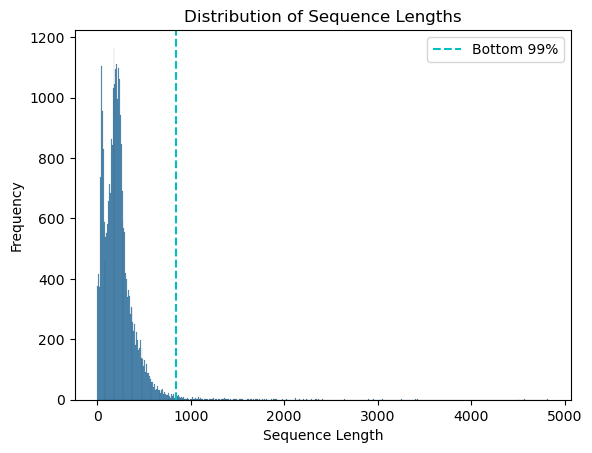

99% of all articles have this number of tokens or less: 840.1500000000015


In [171]:
# Plot to detmine optimal padding length
sns.histplot([len(x) for x in X], bins=500)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')

bottom_99_percentile = np.percentile(sequence_lengths, 99)

plt.axvline(bottom_99_percentile, color='c', linestyle='--', label='Bottom 99%')

plt.legend()
plt.show()

print("99% of all articles have this number of tokens or less:", bottom_99_percentile)

I decided to set 99% as the marker because I needed some kind of baseline and figured that getting an idea of what ballpark a clear supermajority of articles fall under would work for that baseline. I also wanted to avoid possible data loss by setting it much lower than that, which works because this at least removes outliers from the equation.

In [172]:
# Predefined argument 3 - Input Length
maxlen = 840

# Pad (and truncate) for consistent lengths; necessary for a neural network
X = pad_sequences(X, maxlen=maxlen)

### Establish, Export Models
Now I need to set up a pair of models so that I can begin classifying news articles, whether real or fake. Keras provides a few options I can use for deep learning objectives, so I have decided to use a sequential model. The trained model will be pickled and further evaluated in Notebook 3.

**Model A:**

In [182]:
# Create Weight Matrix
def get_weight_matrix(model, word_index):
    vocab_size = len(word_index) + 1
    weight_matrix = np.zeros((vocab_size, embed_dim))
    for word, i in word_index.items():
        if word in model.wv:
            weight_matrix[i] = model.wv.get_vector(word)
    return weight_matrix

In [186]:
# Fetch embedding vectors
embedding_vectors = get_weight_matrix(w2v_a, word_index)

In [178]:
##================#
# Model A
##================#
model_a = Sequential()
model_a.add(Embedding(input_dim=vocab_length, output_dim=embed_dim, weights=[embedding_vectors], input_length=maxlen, trainable=False))
model_a.add(LSTM(units=128))
model_a.add(Dense(units=1, activation='sigmoid'))
model_a.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [179]:
model_a.fit(X, y, epochs=3)

Epoch 1/3
969/969 [==============================] - 1311s 1s/step - loss: 0.0868 - accuracy: 0.9681
Epoch 2/3
969/969 [==============================] - 1313s 1s/step - loss: 0.0396 - accuracy: 0.9863
Epoch 3/3
969/969 [==============================] - 1417s 1s/step - loss: 0.0265 - accuracy: 0.9917


Reminder: The accuracy rating should be taken with a grain of salt at this stage; all it means is that it could predict any of the articles within the training set well, but it has not been validated yet.

In [180]:
# Export the trained model using pickle
pickle.dump(model_a, open('models/fakenews_model_1.pkl', 'wb'))

**Model B:**

In [190]:
# Predefined arguments
embed_dim = 300

In [192]:
embedding_matrix = np.zeros((vocab_length, embed_dim))
for word, i in word_index.items():
    try:
        embedding_vector = w2v_b[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25), embed_dim)

In [194]:
##================#
# Model B
##================#
model_b = Sequential()
model_b.add(Embedding(input_dim=vocab_length, output_dim=embed_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False))
model_b.add(LSTM(units=128))
model_b.add(Dense(units=1, activation='sigmoid'))
model_b.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [197]:
model_b.fit(X, y, epochs=6)

Epoch 1/6
969/969 [==============================] - 814s 840ms/step - loss: 0.0767 - accuracy: 0.9735
Epoch 2/6
969/969 [==============================] - 769s 793ms/step - loss: 0.0512 - accuracy: 0.9830
Epoch 3/6
969/969 [==============================] - 788s 813ms/step - loss: 0.0363 - accuracy: 0.9881
Epoch 4/6
969/969 [==============================] - 858s 885ms/step - loss: 0.0292 - accuracy: 0.9905
Epoch 5/6
969/969 [==============================] - 996s 1s/step - loss: 0.0220 - accuracy: 0.9925
Epoch 6/6
969/969 [==============================] - 944s 974ms/step - loss: 0.0198 - accuracy: 0.9934


In [198]:
# Export the trained model using pickle
pickle.dump(model_b, open('models/fakenews_model_2.pkl', 'wb'))